In [512]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [513]:
# 데이터 로드 및 정보 확인
# 데이터 로드
df = pd.read_csv('Mall_Customers.csv')

# 데이터 정보 확인
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

In [514]:
# 불필요한 열 제거 및 원-핫 인코딩
# 불필요한 인덱스 열 제거
df = df.drop(columns=['CustomerID'])

# 원-핫 인코딩
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# 비지도 학습에서 범주형 변수를 원-핫 인코딩 하면 거리계산이 왜곡될 수 있음
# 따라서 원-핫 인코딩을 하지 않고 수치형 변수만 사용
df = df.drop(columns=['Gender_Male'])
print(df.head())

   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


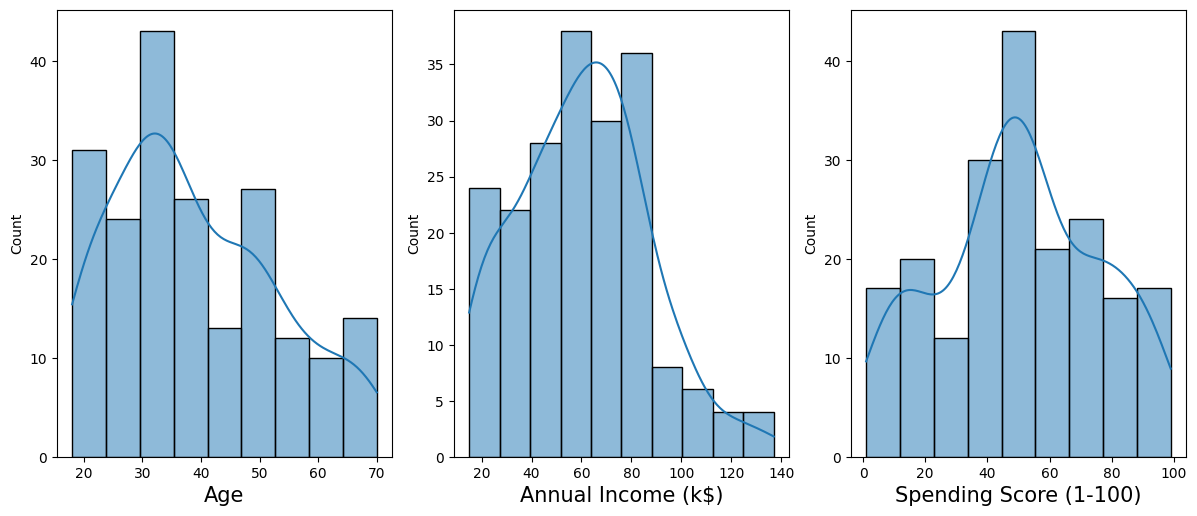

In [515]:
# 히스토그램을 통한 데이터 분포 확인
# 분포 확인
plt.figure(figsize=(20, 15))
plotnumber = 1

for column in df.columns:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.histplot(df[column], kde=True)
        plt.xlabel(column, fontsize=15)
        plotnumber += 1

plt.tight_layout()
plt.show()

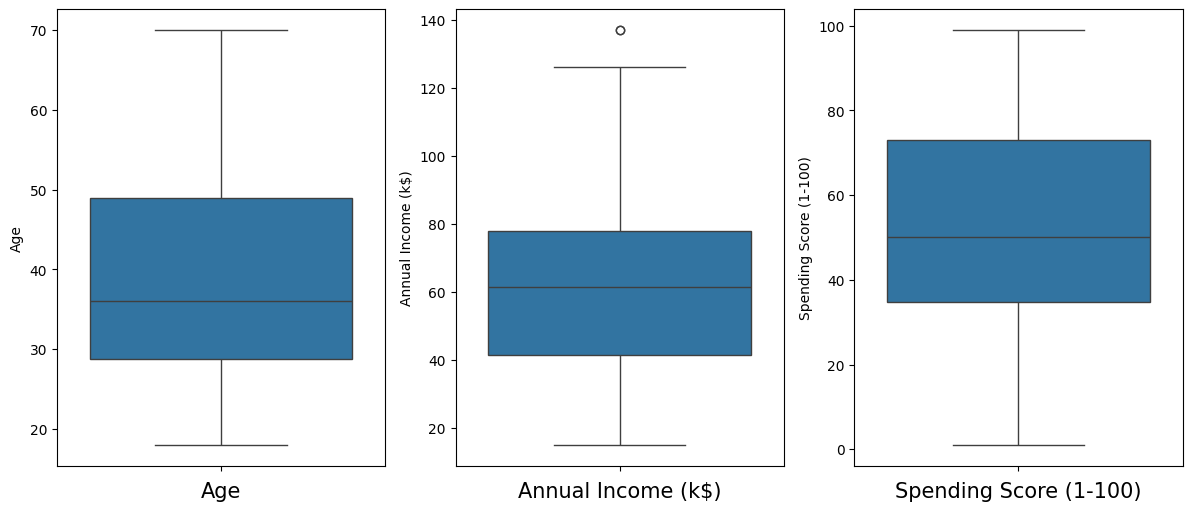

In [516]:
# 박스플롯을 통한 이상치 확인
plt.figure(figsize=(20, 15))
plotnumber = 1

for column in df.columns:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.boxplot(y=df[column], ax=ax)
        plt.xlabel(column, fontsize=15)
        plotnumber += 1

plt.tight_layout()
plt.show()

In [517]:
# 데이터 스케일링
# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
# scaled_df = scaled_df.drop(columns=['Gender_Male'])

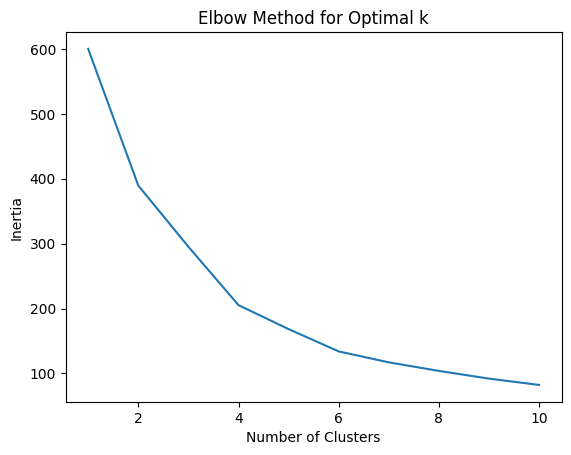

In [518]:
# K-means 클러스터링 (엘보우 방법)
# 엘보우 방법은 K-means 클러스터링에서 최적의 클러스터 수를 결정하는 데 사용됩니다.
# k 값을 1부터 10까지 증가시키면서 각 k 값에 대해 K-means 모델을 학습시키고,
# 각 모델의 이너샤(inertia) 값을 계산합니다.
# 이너샤는 각 클러스터 내 데이터와 중심 사이 거리 제곱의 합으로 클러스터링의 응집도를 나타냅니다.
# 이너샤 값은 클러스터 수가 증가할수록 감소하지만, 감소폭이 급격하게 줄어드는 지점(엘보우)이 최적의 클러스터 수가 됩니다.
# 이너샤 값의 변화를 그래프로 시각화하여 엘보우 지점을 찾습니다.
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

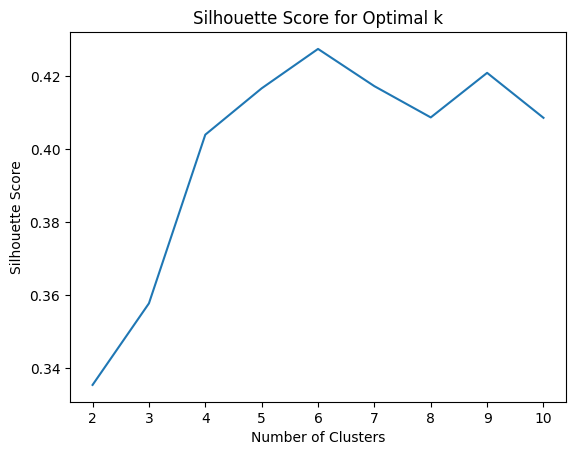

In [519]:
# K-means 클러스터링 (실루엣 점수)
# 실루엣 점수는 클러스터링의 적합성을 평가하는 지표 중 하나입니다.
# 각 데이터 포인트의 실루엣 계수는 해당 데이터 포인트가 자신의 클러스터에 얼마나 잘 속하는지를 나타냅니다.
# 실루엣 계수는 -1에서 1 사이의 값을 가지며, 1에 가까울수록 클러스터링이 잘 된 것으로 평가합니다.
# k 값을 2부터 10까지 증가시키면서 각 k 값에 대해 K-means 모델을 학습시키고,
# 각 모델의 실루엣 점수를 계산합니다.
# 실루엣 점수는 각 데이터 포인트의 실루엣 계수의 평균값입니다.
# 계산된 실루엣 점수를 그래프로 시각화하여 최적의 클러스터 수를 선택합니다.
silhouette_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_labels = kmeans.fit_predict(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [520]:
# K-means 모델 학습 및 클러스터 라벨 저장
# 엘보우 방법과 실루엣 점수를 통해 결정된 최적의 k 값(여기서는 5)을 사용하여 K-means 모델을 학습합니다.
# 학습된 K-means 모델을 사용하여 각 데이터 포인터에 클러스터 라벨을 할당하고,
# 클러스터 라벨을 scaled_df 데이터프레임의 'KMeans_Cluster' 열에 저장합니다.
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_labels = kmeans.fit_predict(scaled_df)
df['KMeans_Cluster'] = kmeans_labels

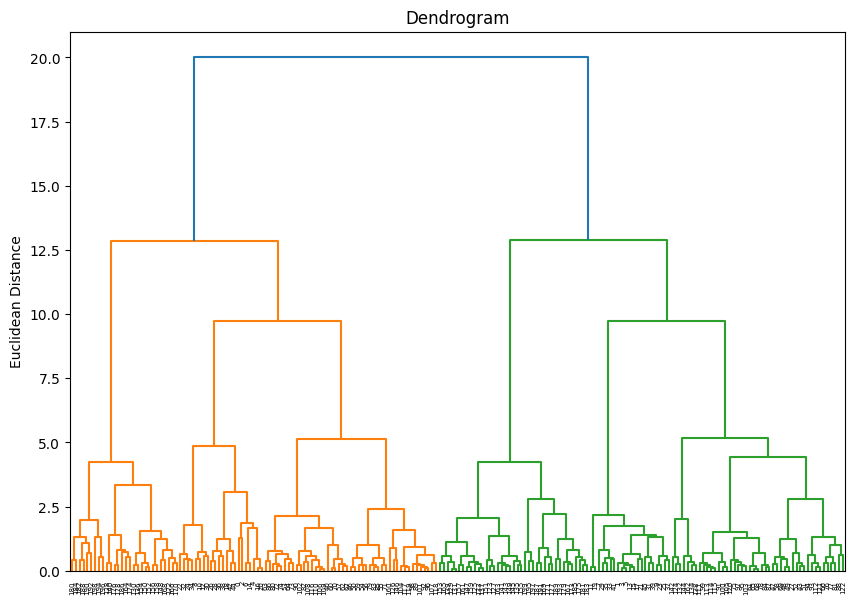

In [521]:
# 덴드로그램 시각화 (계층적 군집화)
# 덴드로그램은 계층적 군집화 결과를 시각적으로 표현한 그래프입니다.
# 덴드로그램에서 각 가지의 길이는 클러스터 간의 거리를 나타냅니다.
# 덴드로그램을 통해 클러스터의 구조를 파악하고, 최적의 클러스터 수를 결정할 수 있습니다.
# linkage 함수를 사용하여 연결 행렬을 계산하고, 덴드로그램을 시각화합니다.
plt.figure(figsize=(10, 7))
dend = dendrogram(linkage(scaled_df, method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')
plt.show()

In [522]:
# 계층적 군집화 모델 학습 및 클러스터 라벨 저장
# 덴드로그램 또는 기타 방법을 통해 결정된 최적의 클러스터 수(여기서는 3)를 사용하여 계층적 군집화 모델을 학습합니다.
# 학습된 계층적 군집화 모델을 사용하여 각 데이터 포인터에 클러스터 라벨을 할당하고,
# 클러스터 라벨을 scaled_df 데이터프레임의 'Agg_Cluster' 열에 저장합니다.
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_cluster.fit_predict(scaled_df)
df['Agg_Cluster'] = agg_labels

In [523]:
# DBSCAN 모델 학습 및 클러스터 라벨 저장
# DBSCAN은 밀도 기반 클러스터링 알고리즘으로, 클러스터 수를 미리 지정하지 않아도 됩니다.
# DBSCAN 모델을 학습하고, 각 데이터 포인터에 클러스터 라벨을 할당합니다.
# 클러스터 라벨을 scaled_df 데이터프레임의 'DBSCAN_Cluster' 열에 저장합니다.
# DBSCAN은 노이즈 데이터에 대해 -1 라벨을 할당합니다.
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df)
df['DBSCAN_Cluster'] = dbscan_labels

In [524]:
# GMM 모델 학습 및 클러스터 라벨 저장
# GMM은 혼합 가우시안 모델 기반의 클러스터링 알고리즘으로, 각 클러스터가 가우시안 분포를 따른다고 가정합니다.
# GMM 모델을 학습하고, 각 데이터 포인터에 클러스터 라벨을 할당합니다.
# 클러스터 라벨을 scaled_df 데이터프레임의 'GMM_Cluster' 열에 저장합니다.
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_labels = gmm.fit_predict(scaled_df)
df['GMM_Cluster'] = gmm_labels

In [525]:
# PCA 적용
# PCA(주성분 분석)은 데이터의 차원을 축소하는 데 사용되는 기법입니다.
# 고차원 데이터를 2차원으로 축소하여 시각화하기 쉽게 만듭니다.
# 차원 축소를 통해 데이터의 중요한 특징을 보존하면서, 시각화 및 분석을 용이하게 만듭니다.
# PCA를 적용한 결과를 scaled_df 데이터프레임에 'pca_x', 'pca_y' 열로 저장합니다.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)
df['pca_x'] = pca_result[:, 0]
df['pca_y'] = pca_result[:, 1]

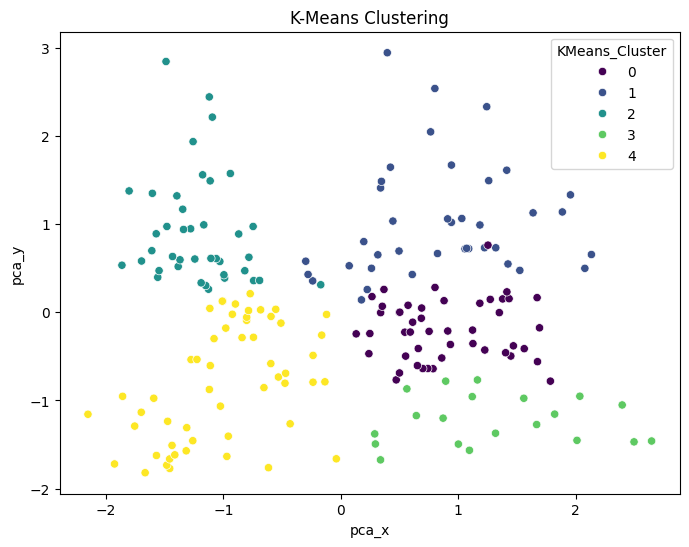

In [526]:
# 클러스터링 결과 시각화 (K-means)
# K-means 클러스터링 결과를 2차원 산점도로 시각화합니다.
# PCA를 통해 축소된 데이터를 사용하여 각 클러스터를 다른 색상으로 표시합니다.
# 시각화를 통해 클러스터 간의 분포를 파악할 수 있습니다.
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='KMeans_Cluster', palette='viridis', data=df)
plt.title('K-Means Clustering')
plt.show()

In [527]:
# PCA 적용 (3차원 시각화를 위한 PCA)
pca = PCA(n_components=3)  # 3차원 시각화를 위해 3개의 주성분 선택
pca_result = pca.fit_transform(scaled_df)
df['pca_x'] = pca_result[:, 0]
df['pca_y'] = pca_result[:, 1]
df['pca_z'] = pca_result[:, 2]

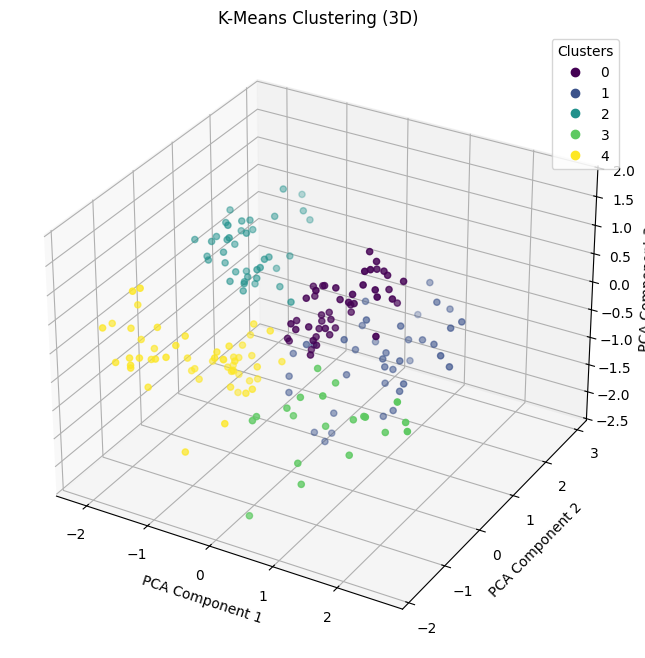

In [528]:
# K-means 클러스터 시각화 (3차원)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['KMeans_Cluster'], cmap='viridis')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('K-Means Clustering (3D)')

# 범례 추가
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

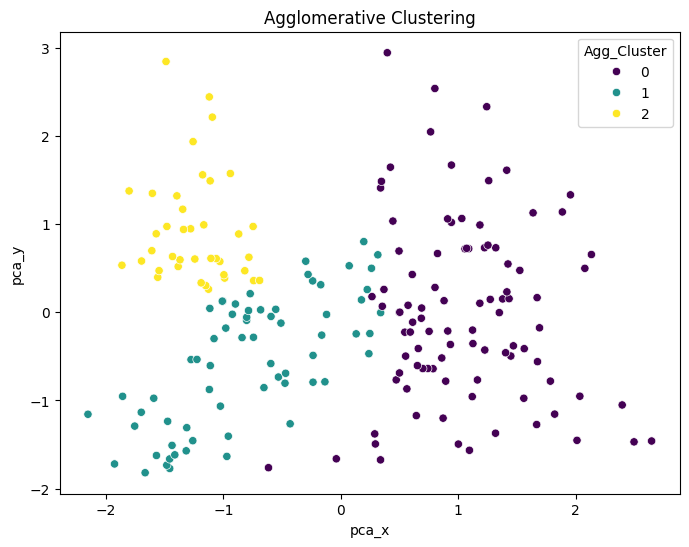

In [529]:
# 클러스터링 결과 시각화 (계층적 군집화)
# 계층적 군집화 결과를 2차원 산점도로 시각화합니다.
# PCA를 통해 축소된 데이터를 사용하여 각 클러스터를 다른 색상으로 표시합니다.
# 시각화를 통해 클러스터 간의 분포를 파악할 수 있습니다.
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='Agg_Cluster', palette='viridis', data=df)
plt.title('Agglomerative Clustering')
plt.show()

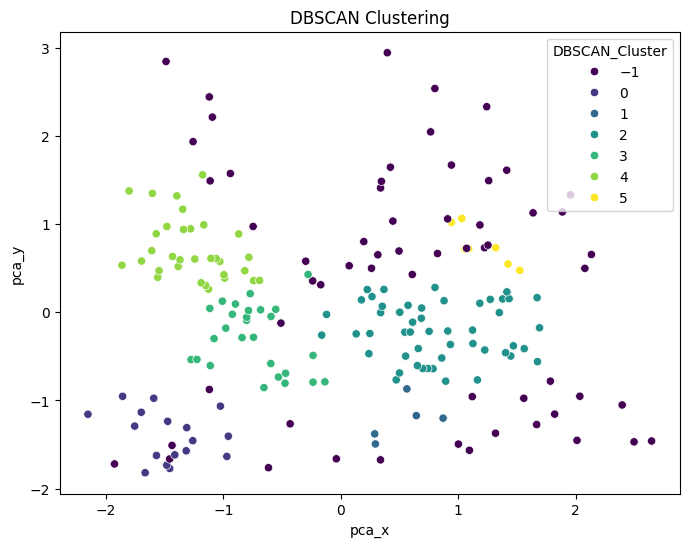

In [530]:
# 클러스터링 결과 시각화 (DBSCAN)
# DBSCAN 클러스터링 결과를 2차원 산점도로 시각화합니다.
# PCA를 통해 축소된 데이터를 사용하여 각 클러스터를 다른 색상으로 표시합니다.
# 시각화를 통해 클러스터 간의 분포를 파악할 수 있습니다.
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='DBSCAN_Cluster', palette='viridis', data=df)
plt.title('DBSCAN Clustering')
plt.show()

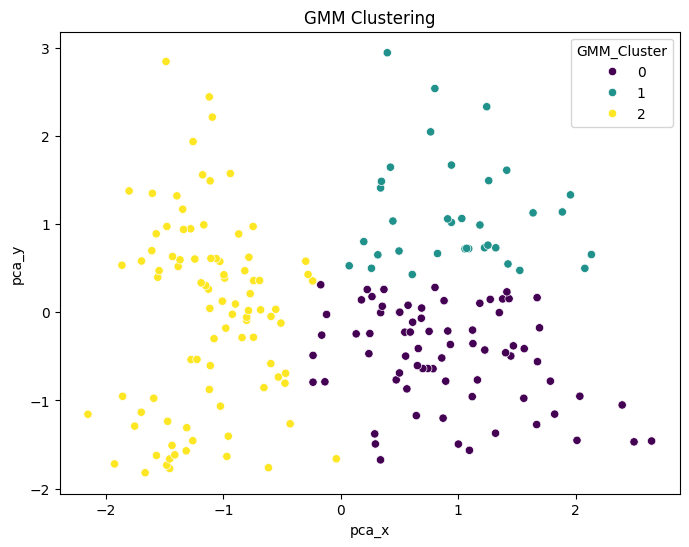

In [531]:
# 클러스터링 결과 시각화 (GMM)
# GMM 클러스터링 결과를 2차원 산점도로 시각화합니다.
# PCA를 통해 축소된 데이터를 사용하여 각 클러스터를 다른 색상으로 표시합니다.
# 시각화를 통해 클러스터 간의 분포를 파악할 수 있습니다.
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='GMM_Cluster', palette='viridis', data=df)
plt.title('GMM Clustering')
plt.show()

In [532]:
# 클러스터별 평균 특징 분석 (K-means)
# K-means 클러스터링 결과에 따라 그룹화하여 각 클러스터의 평균 특징을 분석합니다.
# 이를 통해 각 클러스터에 속한 고객의 특징을 파악하고, 클러스터별 의미를 부여할 수 있습니다.
print("--- K-means 클러스터별 평균 특징 분석 ---")
kmeans_cluster_summary = df.groupby('KMeans_Cluster').mean()
print(kmeans_cluster_summary)

--- K-means 클러스터별 평균 특징 분석 ---
                      Age  Annual Income (k$)  Spending Score (1-100)  \
KMeans_Cluster                                                          
0               55.638298           54.382979               48.851064   
1               39.871795           86.102564               19.358974   
2               32.875000           86.100000               81.525000   
3               46.250000           26.750000               18.350000   
4               25.185185           41.092593               62.240741   

                Agg_Cluster  DBSCAN_Cluster  GMM_Cluster     pca_x     pca_y  \
KMeans_Cluster                                                                 
0                  0.085106        1.872340     0.021277  0.899383 -0.197204   
1                  0.230769        0.333333     1.025641  0.850509  1.021244   
2                  1.975000        3.000000     1.950000 -1.208516  0.914846   
3                  0.000000       -0.200000     0.000000 

In [533]:
# 클러스터별 평균 특징 분석 (계층적 군집화)
# 계층적 군집화 결과에 따라 그룹화하여 각 클러스터의 평균 특징을 분석합니다.
# 이를 통해 각 클러스터에 속한 고객의 특징을 파악하고, 클러스터별 의미를 부여할 수 있습니다.
print("\n--- 계층적 군집화 클러스터별 평균 특징 분석 ---")
agg_cluster_summary = df.groupby('Agg_Cluster').mean()
print(agg_cluster_summary)


--- 계층적 군집화 클러스터별 평균 특징 분석 ---
                   Age  Annual Income (k$)  Spending Score (1-100)  \
Agg_Cluster                                                          
0            49.915789           59.063158               32.515789   
1            26.560606           47.363636               56.787879   
2            32.692308           86.538462               82.128205   

             KMeans_Cluster  DBSCAN_Cluster  GMM_Cluster     pca_x     pca_y  \
Agg_Cluster                                                                    
0                  1.031579        0.905263     0.368421  1.048547 -0.007196   
1                  3.318182        1.318182     1.575758 -0.779430 -0.539354   
2                  2.000000        3.102564     2.000000 -1.235118  0.930282   

                pca_z  
Agg_Cluster            
0            0.075930  
1           -0.445620  
2            0.569168  


In [534]:
# 클러스터별 평균 특징 분석 (DBSCAN)
# DBSCAN 클러스터링 결과에 따라 그룹화하여 각 클러스터의 평균 특징을 분석합니다.
# 이를 통해 각 클러스터에 속한 고객의 특징을 파악하고, 클러스터별 의미를 부여할 수 있습니다.
print("\n--- DBSCAN 클러스터별 평균 특징 분석 ---")
dbscan_cluster_summary = df.groupby('DBSCAN_Cluster').mean()
print(dbscan_cluster_summary)


--- DBSCAN 클러스터별 평균 특징 분석 ---
                      Age  Annual Income (k$)  Spending Score (1-100)  \
DBSCAN_Cluster                                                          
-1              40.133333           68.533333               31.533333   
 0              23.764706           25.823529               78.176471   
 1              38.200000           27.800000               31.800000   
 2              53.666667           54.156863               48.411765   
 3              24.107143           54.321429               50.464286   
 4              32.750000           80.875000               83.625000   
 5              43.857143           78.714286               14.571429   

                KMeans_Cluster  Agg_Cluster  GMM_Cluster     pca_x     pca_y  \
DBSCAN_Cluster                                                                 
-1                    1.933333     0.450000     1.033333  0.562204  0.334132   
 0                    4.000000     1.000000     2.000000 -1.468068 -1.3

In [535]:
# 클러스터별 평균 특징 분석 (GMM)
# GMM 클러스터링 결과에 따라 그룹화하여 각 클러스터의 평균 특징을 분석합니다.
# 이를 통해 각 클러스터에 속한 고객의 특징을 파악하고, 클러스터별 의미를 부여할 수 있습니다.
print("\n--- GMM 클러스터별 평균 특징 분석 ---")
gmm_cluster_summary = df.groupby('GMM_Cluster').mean()
print(gmm_cluster_summary)


--- GMM 클러스터별 평균 특징 분석 ---
                   Age  Annual Income (k$)  Spending Score (1-100)  \
GMM_Cluster                                                          
0            50.837838           46.675676               40.486486   
1            41.685714           88.228571               17.285714   
2            28.010989           61.208791               70.758242   

             KMeans_Cluster  Agg_Cluster  DBSCAN_Cluster     pca_x     pca_y  \
GMM_Cluster                                                                    
0                  1.135135     0.162162        1.364865  0.899474 -0.489162   
1                  0.971429     0.114286        0.200000  0.995408  1.109262   
2                  3.043956     1.406593        2.043956 -1.114290 -0.028859   

                pca_z  
GMM_Cluster            
0            0.338946  
1           -0.753779  
2            0.014288  


In [536]:
# 분류 모델 학습 (로지스틱 회귀, 랜덤 포레스트)
# K-means 클러스터링 결과를 예측 모델의 목표 변수로 사용하여 분류 모델을 학습합니다.
# 클러스터 라벨을 예측하는 분류 모델을 만들어, 새로운 데이터가 어떤 클러스터에 속할지 예측할 수 있습니다.
# 로지스틱 회귀와 랜덤 포레스트 모델을 학습하고, 각 모델의 분류 성능(정확도, 정밀도, 재현율, F1-score)을 평가합니다.
X = df.drop(columns=['KMeans_Cluster', 'Agg_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster', 'pca_x', 'pca_y']) # 클러스터 라벨과 PCA 결과 제거
y = df['KMeans_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델
logistic_model = LogisticRegression(random_state=42, solver='liblinear')
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

print("\n--- Logistic Regression Model ---")
print(classification_report(y_test, logistic_predictions))
print(f"Accuracy: {accuracy_score(y_test, logistic_predictions):.4f}")

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("\n--- Random Forest Model ---")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")


--- Logistic Regression Model ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      1.00      1.00        15
           2       1.00      0.90      0.95        10
           3       1.00      0.80      0.89         5
           4       0.94      1.00      0.97        15

    accuracy                           0.97        60
   macro avg       0.97      0.94      0.95        60
weighted avg       0.97      0.97      0.97        60

Accuracy: 0.9667

--- Random Forest Model ---
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        15

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99       